<a href="https://colab.research.google.com/github/alexgaskell10/NLP_Translation/blob/master/notebooks/stuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install transformers

In [0]:
import torch
from torch.nn import Linear, ModuleList
from torch import optim, nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import random
import time
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import os
torch.set_printoptions(3)

### Import dataset

In [0]:
########### ENGLISH - GERMAN ############

# Download and unzip the data
from os.path import exists
if not exists('ende_data.zip'):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip

# Load data into variables
with open("./train.ende.src", "r") as ende_src:
    en_corpus = ende_src.read().split('\n')[:-1]
with open("./train.ende.mt", "r") as ende_src:
    de_corpus = ende_src.read().split('\n')[:-1]
with open("./train.ende.scores", "r") as ende_src:
    scores = [float(x) for x in ende_src.read().split('\n')[:-1]]

# Load data into variables
with open("./dev.ende.src", "r") as ende_src:
    en_corpus_val = ende_src.read().split('\n')[:-1]
with open("./dev.ende.mt", "r") as ende_src:
    de_corpus_val = ende_src.read().split('\n')[:-1]
with open("./dev.ende.scores", "r") as ende_src:
    scores_val = [float(x) for x in ende_src.read().split('\n')[:-1]]


# Load data into variables
with open("./test.ende.src", "r") as ende_src:
    en_corpus_test = ende_src.read().split('\n')[:-1]
with open("./test.ende.mt", "r") as ende_src:
    de_corpus_test = ende_src.read().split('\n')[:-1]


print(en_corpus[0])
print(de_corpus[0])
print(scores[0])

print(en_corpus_test[0])
print(de_corpus_test[0])

In [0]:
##### UNCOMMENT BELOW TO USE ON CHINESE DATASET ######

# # ############ ENGLISH - CHINESE ############

# # Download and unzip the data
# from os.path import exists
# if not exists('enzh_data.zip'):
#     !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
#     !unzip enzh_data.zip

# # Load data into variables
# with open("./train.enzh.src", "r") as ende_src:
#     en_corpus = ende_src.read().split('\n')[:-1]
# with open("./train.enzh.mt", "r") as ende_src:
#     de_corpus = ende_src.read().split('\n')[:-1]
# with open("./train.enzh.scores", "r") as ende_src:
#     scores = [float(x) for x in ende_src.read().split('\n')[:-1]]

# print(en_corpus[0])
# print(de_corpus[0])
# print(scores[0])

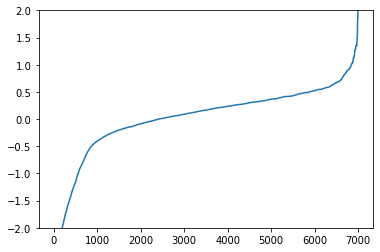

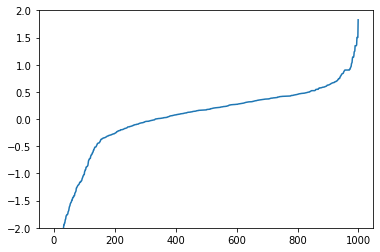

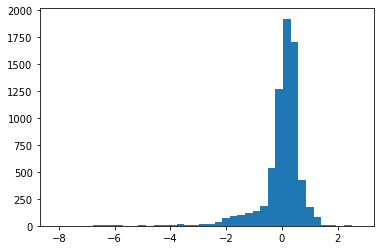

In [6]:
### Basic analysis of distribution of scores

# Training scores
plt.plot(sorted(scores))
plt.ylim([-2,2])
plt.show()

# Validation scores
plt.plot(sorted(scores_val))
plt.ylim([-2,2])
plt.show()

# Histogram of training scores
plt.hist(sorted(scores), bins=40)
plt.show()

### Preprocessing

In [0]:
class Preprocessor:
    def __init__(self, device, bert_config):
        '''Class for containing the preprocessing methods for this notebook.
        
        params:
        :device: pass in GPU if available. Otherwise pass in CPU
        :bert_config: configuration of BERT as per the Huggingface
        Transformers library (https://huggingface.co)
        '''
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained(bert_config)

    def get_input_tensor(self, en_corpus, de_corpus):
        '''Method to preprocess the raw source and taget sentences. Performs
        the following preprocessing:

        - Tokenize
        - Convert to torch tensor
        - Pad accordingly
        - Concatenate
        
        :returns inp_tensor: torch Tensor ready to be fed into BERT
        '''
        # Convert input sequences to correct format
        N = len(en_corpus)

        # Tokenize corpora
        inputs_en, inputs_de = [],[]
        max_len_en, max_len_de = 0,0
            
        for i in range(N):
            # English
            seq = en_corpus[i][:-1]
            input_ids = torch.tensor([self.tokenizer.encode(seq, add_special_tokens=True)])
            inputs_en.append(input_ids)
            if input_ids.shape[-1] > max_len_en:
                max_len_en = input_ids.shape[-1]

            # German
            seq = de_corpus[i][:-1]
            input_ids = torch.tensor([self.tokenizer.encode(seq, add_special_tokens=True)])
            inputs_de.append(input_ids)
            if input_ids.shape[-1] > max_len_de:
                max_len_de = input_ids.shape[-1]

        # Combine tokens into single tensor
        inp_tensor = torch.zeros((N, max_len_en + max_len_de - 2))      # <-- -2 because special tokens are not necessary at beginning of German sequence

        for i in range(N):
            # Add English tokens
            en_tokens = inputs_en[i].squeeze()
            inp_tensor[i, : len(en_tokens)] = en_tokens

            # Add German tokens
            de_tokens = inputs_de[i][:,2:].squeeze()      # <-- ignore first 2 tokens as these are special tokens and unnecessary in this case
            inp_tensor[i, max_len_en : max_len_en + len(de_tokens)] = de_tokens

        return inp_tensor

    def attention_mask(self, list_input_tensor):
        '''Method to compute the attention mask for any tensor for use
        with BERT.
        '''
        list_attention_masks = []
        for input_tensor in list_input_tensor:
            attention_mask = torch.zeros((input_tensor.shape))
            attention_mask[input_tensor != 0] = 1
            list_attention_masks.append(attention_mask)

        return list_attention_masks

    def get_batches(self, inp_tensor, scores, BATCH_N):
        '''Splits the input tensor and scores into batches of 
        length BATCH_N.
        '''

        inp_tensor = inp_tensor
        scores = torch.tensor(scores).view(-1,1)

        assert len(inp_tensor) == len(scores), "Different number of samples and labels"

        # Split data into train, test and val batches
        X_batches = torch.split(inp_tensor, BATCH_N)
        y_batches = torch.split(scores, BATCH_N)
        print(len(X_batches), X_batches[0].shape)

        # Create attention masks
        mask = self.attention_mask(X_batches)

        # Batch X, mask and y together
        batches = [(X, mask, y) for X,mask,y in zip(X_batches, mask, y_batches)]

        return batches

    def get_test_batches(self, inp_tensor, BATCH_N):
        '''Compiles batches for the test tensor
        '''
        
        inp_tensor = inp_tensor

        # Split data into train, test and val batches
        X = torch.split(inp_tensor, BATCH_N)

        # Create attention masks
        X_mask = self.attention_mask(X)

        # Batch X and mask together
        batches = [(x, mask) for x,mask in zip(X, X_mask)]

        return batches


def get_bert_embeddings(bert_model, batches):
    '''Method to use BERT for computing embeddings (so BERT 
    can be frozen to prevent it from training).
    '''
    bert_model = bert_model.to(device)
    embeddings = []
    with torch.no_grad():
       for n, batch in enumerate(batches):
           
            X = batch[0].to(device=device, dtype=torch.long)
            mask = batch[1].to(device)
            
            try:
                y = batch[2].to(device)

                embs = bert_model.bert_embed(X, mask)
                embeddings.append((embs, y))
            except IndexError:
                embs = bert_model.bert_embed(X, mask)
                embeddings.append(embs)


            torch.cuda.empty_cache()

            if n % 10 == 0:
                print(f'{n} / {len(batches)} complete')

    return embeddings


### Model

In [0]:
class Network(nn.Module):
    def __init__(self, device, input_shape):
        super(Network, self).__init__()
        self.batch_size, self.seq_len = input_shape
        self.device = device
        self.model = nn.Sequential(
            Linear(in_features=768, out_features=500, bias=True),
            nn.ReLU(True),
            Linear(in_features=500, out_features=250, bias=True),
            nn.ReLU(True),
            Linear(in_features=250, out_features=100, bias=True),
            nn.ReLU(True),
            Linear(in_features=100, out_features=1, bias=True),
        ).to(device)
        # self.model = nn.Sequential(                   # <-- uncomment this section and comment the section above to use the BERT + Linear Layer model
        #     Linear(in_features=768, out_features=1, bias=True),
        # ).to(device)

    def forward(self, X):
        X = self.model(X.float())
        return X

    # def PearsonLoss(self, x, y):
    #     vx = x - torch.mean(x)
    #     vy = y - torch.mean(y)    
    #     return (torch.ones(1).cuda() - torch.sum(vx * vy * torch.rsqrt(torch.sum(vx ** 2)) * torch.rsqrt(torch.sum(vy ** 2))))**2

    def loss(self, scores, pred_scores):
        rmse = (((pred_scores - scores)**2).mean())**0.5
        return rmse

    def check_r(self, y_pred, y):
        return pearsonr(y_pred.cpu().squeeze(), y.cpu().squeeze())[0]


class BertRegressor(nn.Module):
    def __init__(self, input_shape, bert_config, device):
        super(BertRegressor, self).__init__()
        self.device = device
        self.bert = BertModel.from_pretrained(bert_config)
        self.net = Network(device, input_shape)

    def forward_1(self, X, attention_mask=None):
        '''Forward pass with BERT unfrozen using CLS token
        '''
        if attention_mask is not None:
            X = self.bert(X, attention_mask)[0].view(X.shape[0], -1)    
        else:
            X = self.bert(X)[0].view(X.shape[0], -1)

        X = self.net(X)
        return X

    def forward_2(self, X, attention_mask=None):
        '''Forward pass with BERT unfrozen
        '''
        if attention_mask is not None:
            X = self.bert(X, attention_mask)[1]
        else:
            X = self.bert(X)[1]

        X = self.net(X)
        return X

    def bert_embed(self, X, attention_mask=None):
        '''Forward pass with BERT frozen
        '''
        if attention_mask is not None:
            X = self.bert(X, attention_mask)[1]
        else:
            X = self.bert(X)[1]

        return X

    # def loss(self, scores, pred_scores):
    #     rmse = (((pred_scores - scores)**2).mean())**0.5
    #     return rmse

    # def check_r(self, y_pred, y):
    #     return pearsonr(y_pred.cpu().squeeze(), y.cpu().squeeze())[0]

    # def params(self):
    #     return list(self.bert.parameters()) + list(self.net.parameters())

    def __call__(self, X, attention_mask=None):
        return self.forward_2(X, attention_mask)


In [0]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Hyperparameters
bert_config = 'bert-base-multilingual-cased'
BATCH_N = 32        
EPOCHS = 30         
LR = 1e-4           

# Set seeds
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Preprocessing
preprocessor = Preprocessor(device, bert_config)
input_tensor_train = preprocessor.get_input_tensor(en_corpus, de_corpus)
input_tensor_val = preprocessor.get_input_tensor(en_corpus_val, de_corpus_val)

batches_train = preprocessor.get_batches(input_tensor_train, scores, BATCH_N)
batches_val = preprocessor.get_batches(input_tensor_val, scores_val, BATCH_N)

bert_model = BertRegressor(batches_train[0][0].shape, bert_config, device)
train_batches_emb = get_bert_embeddings(bert_model, batches_train)
val_batches_emb = get_bert_embeddings(bert_model, batches_val)

print(len(input_tensor_train))

### Uncomment below to use multiple vaidation sets ###
# # Preprocessing
# b = 1000
# preprocessor = Preprocessor(device, bert_config)
# input_tensor_train = preprocessor.get_input_tensor(en_corpus[:b] + en_corpus[b+500:], de_corpus[:b] + de_corpus[b+500:])
# input_tensor_val = preprocessor.get_input_tensor(en_corpus_val, de_corpus_val)
# input_tensor_val_2 = preprocessor.get_input_tensor(en_corpus[b:b+500], de_corpus[b:b+500])

# scores_ = scores[:b] + scores[b+500:]
# scores_val = scores_val
# scores_val_2 = scores[b:b+500]

# batches_train = preprocessor.get_batches(input_tensor_train, scores_, BATCH_N)
# batches_val = preprocessor.get_batches(input_tensor_val, scores_val, BATCH_N)
# batches_val_2 = preprocessor.get_batches(input_tensor_val_2, scores_val_2, BATCH_N)

# bert_model = BertRegressor(batches_train[0][0].shape, bert_config, device)
# train_batches_emb = get_bert_embeddings(bert_model, batches_train)
# val_batches_emb = get_bert_embeddings(bert_model, batches_val)
# val_batches_emb_2 = get_bert_embeddings(bert_model, batches_val_2)

# print(len(input_tensor_train))

In [0]:
import sys

def validation(val_batches):
    '''Vaidation loop'''

    t0 = time.time()
    eval_loss = 0
    correlations = []

    with torch.no_grad():        
        for batch in val_batches:
            # Untie batch and put on GPU
            X = batch[0].to(device=device, dtype=torch.float)
            y = batch[1].to(device)

            y_pred = model(X)     

            # Compute and record batch accuracy
            corr = model.check_r(y_pred.squeeze(), y.squeeze())
            correlations.append(corr)

    # Report the final accuracy for this validation run.
    print(f"|  Correlation: {np.mean(correlations):.3f}     |")
    # print(f"|  Validation took: {time.time() - t0:0f} s |")

    torch.cuda.empty_cache()


def train(model, train_batches, val_batches, epochs):
    '''Main training loop'''

    losses = []
    model = model.to(device)
    
    for epoch_i in range(epochs):
        
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()
        total_loss = 0

        for step, batch in enumerate(train_batches):

            # Untie batch and put on GPU
            X = batch[0].to(device=device, dtype=torch.float)
            y = batch[1].to(device)
            
            model.zero_grad()                   # Reset grads
            y_pred = model(X)                   # Forward pass
            
            loss = model.loss(y, y_pred)        # Compute loss
            total_loss += loss.item()           # Accumulate loss
            loss.backward()                     # Backward pass

            optimizer.step()                    # Update params

            # if step % 50 == 0:
            #     # Progress update every 40 batches                
            #     print('  Batch {:>5,}  of  {:>5,}    |    Elapsed: {:.0f}s.'.format(step, len(train_batches), time.time() - t0))
            #     print(f'  Loss = {loss.item():.2f}')

            torch.cuda.empty_cache()            # Clear GPU cache to avoid memory issues
            
        # Compute and store avg loss
        avg_train_loss = total_loss / train_batches[0][0].shape[0]
        losses.append(avg_train_loss)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:.0f}s".format(time.time() - t0))

        validation(val_batches) 

    print("")
    print("Training complete!")


def writeScores(scores):
    fn = dir_path + "predictions.txt"
    print("")
    with open(fn, 'w') as output_file:
        for idx,x in enumerate(scores):
            # out =  metrics[idx]+":"+str("{0:.2f}".format(x))+"\n"
            # print(out)
            output_file.write(f"{x}\n")


def get_test_preds(model, en_test, de_test):

    torch.cuda.empty_cache()
    # Preprocessing
    preprocessor = Preprocessor(device, bert_config)
    input_tensor = preprocessor.get_input_tensor(en_test, de_test)
    batches = preprocessor.get_test_batches(input_tensor, BATCH_N=50)
    batches_emb = get_bert_embeddings(bert_model, batches)

    # empty_tensor = torch.zeros_like(input_tensor_train)

    y_preds = []
    with torch.no_grad():
        for n,batch in enumerate(batches_emb):
            
            X = batch.to(device=device, dtype=torch.float)
            y_pred = model(X)

            y_preds.extend(y_pred.squeeze().tolist())
            print(f'{n} / {len(batches)} complete')

    writeScores(y_preds)
    torch.cuda.empty_cache()


In [0]:
torch.cuda.empty_cache()
# Model to train
model = Network(device, batches_train[0][0].shape)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, eps=1e-8)

train(model, train_batches_emb, val_batches_emb,  epochs=EPOCHS)

# # Directory for saving reconstructions + models
# dir_path = '/content/drive/My Drive/Documents/Imperial/NLP/NLP_Translation/notebooks/models/'

# try:
#     print(os.listdir(dir_path))
# except:
#     from google.colab import drive
#     drive.mount('/content/drive')

# torch.save(model.state_dict(), dir_path + '/bert_MLP.pth')

In [0]:
dir_path = '/content/drive/My Drive/Documents/Imperial/NLP/NLP_Translation/notebooks/models/'

try:
    print(os.listdir(dir_path))
except:
    from google.colab import drive
    drive.mount('/content/drive')

# # torch.cuda.empty_cache()
# model = Network(device, batches_train[0][0].shape)
# torch.cuda.empty_cache()
# state_dict = torch.load(
#     dir_path + '/bert_MLP.pth',
#     # map_location=lambda storage, loc: storage.cuda(torch.device("cpu")),
# )
# model.load_state_dict(state_dict)

get_test_preds(model, en_corpus_test, de_corpus_test)